In [3]:
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import sqlite3
import matplotlib.pyplot as plt
import operator
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

/Users/tonyzeng/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
# example for how to create the data frame of people who voted "yes" for each bill in 1990
votes_yes_1990 = pd.read_csv("1990_yes_votes.csv")


In [7]:
# Given dataframe of people who voted "yes" for each bill in each year, generate dictionary for each year:
#   params: 
#       * vote_history -- a pandas df with cols "bill_number, display_name, first_name, id, last_name, party, state"
#                         representing yes votes from a particular year
#                         (could be an entry in the dictionary vote_yes)
#   returns:
#       * pairs_from_year -- a dictionary pairs_from_year such that 
#             pairs_from_year[(sen1_id, sen2_id)]= number of times senator1 & senator2 both voted "yes" in given year
#             sen1_id < sen2_id
def gen_pairs_from_vote(vote_history):
    pairs_from_year = {}
    for name, group in vote_history.groupby("bill_number"):
        print('anme', name,group)
        pairs_bill = itertools.combinations(group["id"], 2)
        for pair in list(pairs_bill):
            id1 = min(pair)
            id2 = max(pair)
            if (id1, id2) in pairs_from_year:
                pairs_from_year[(id1, id2)] += 1
            else:
                pairs_from_year[(id1, id2)] = 1
    return pairs_from_year

In [4]:
# given a year and a threshold of votes to exclude, constructs a weighted graph of senator voting behavior
#   params: 
#       year: year to make graph of
#       votes_to_exclude: if a bill has more than threshold votes of yes, we exclude it
#   returns:
#       weighted graph of senate voting behavior      
def create_graph(year, threshold):
    csv = str(year) + '_yes_votes.csv'
    df = pd.read_csv(csv)
    conn = sqlite3.connect(":memory:")
    df.to_sql('votes', conn, if_exists='replace', index=False)
    
    #selects all bills with fewer than votes_to_exclude yes votes
    query = '''
    SELECT * from votes
    where bill_number in
    (
        SELECT bill_number FROM
        (
            SELECT bill_number, count(1) as num_yes
            FROM votes
            GROUP BY 1
        )
        WHERE num_yes <='''+ str(threshold)+'''
    )
    '''
    df_pruned = pd.read_sql_query(query, conn)
    df_pruned.to_sql('votes', conn, if_exists='replace', index=False)
    query = '''
    SELECT e1,e2,count(1)as weight from 
    (
        Select A.display_name as e1, B.display_name as e2 
        FROM votes A 
        JOIN votes B 
        on (A.bill_number = B.bill_number AND A.display_name != B.display_name)
    ) 
        WHERE e1 < e2
        GROUP BY 1,2
    '''
    weighted = pd.read_sql_query(query, conn)
    return nx.from_pandas_dataframe(weighted, 'e1', 'e2', 'weight')
    

In [9]:
#example on how to use create_graph
g1990 = create_graph(1990, 80)
nx.info(g1990)

/Users/tonyzeng/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1165: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)


'Name: \nType: Graph\nNumber of nodes: 101\nNumber of edges: 5024\nAverage degree:  99.4851'

In [6]:
# potential issue: the betweenness centralities seem to be the same for EVERYONE. 
# same results after playing with threshold
nx.degree_centrality(g1990)
nx.betweenness_centrality(g1990, weight='weight')

{u'Adams (D-WA)': 0.0,
 u'Akaka (D-HI)': 0.0,
 u'Armstrong (R-CO)': 0.14629629629629629,
 u'Baucus (D-MT)': 0.0,
 u'Bentsen (D-TX)': 0.0,
 u'Biden (D-DE)': 0.0,
 u'Bingaman (D-NM)': 0.0,
 u'Bond (R-MO)': 0.0,
 u'Boren (D-OK)': 0.0,
 u'Boschwitz (R-MN)': 0.0,
 u'Bradley (D-NJ)': 0.06696969696969694,
 u'Breaux (D-LA)': 0.0,
 u'Bryan (D-NV)': 0.0,
 u'Bumpers (D-AR)': 0.0,
 u'Burdick (D-ND)': 0.0,
 u'Burns (R-MT)': 0.0,
 u'Byrd (D-WV)': 0.0,
 u'Chafee (R-RI)': 0.0,
 u'Coats (R-IN)': 0.0,
 u'Cochran (R-MS)': 0.0,
 u'Cohen (R-ME)': 0.0,
 u'Conrad (D-ND)': 0.0,
 u'Cranston (D-CA)': 0.056127946127946124,
 u"D'Amato (R-NY)": 0.0,
 u'Danforth (R-MO)': 0.0,
 u'Daschle (D-SD)': 0.0,
 u'DeConcini (D-AZ)': 0.0,
 u'Dixon (D-IL)': 0.0,
 u'Dodd (D-CT)': 0.0,
 u'Dole (R-KS)': 0.0,
 u'Domenici (R-NM)': 0.0,
 u'Durenberger (R-MN)': 0.0,
 u'Exon (D-NE)': 0.0,
 u'Ford (D-KY)': 0.0,
 u'Fowler (D-GA)': 0.0,
 u'Garn (R-UT)': 0.0,
 u'Glenn (D-OH)': 0.0,
 u'Gore (D-TN)': 0.0,
 u'Gorton (R-WA)': 0.0,
 u'Graham (D

In [17]:
# max betweenness centrality over time
max_bets_over_time = {} # key: year, value: max betweenness score
for i in range(1989, 2013):
    g = create_graph(i,85)
    bets = nx.betweenness_centrality(g, weight='weight')
    max_bet = max(bets.iterkeys(), key=(lambda key: bets[key]))
    max_bets_over_time[i] = bets[max_bet]

print(max_bets_over_time)

{1989: 0.2674362674362674, 1990: 0.9203030303030303, 1991: 0.9933333333333333, 1992: 0.7576767676767677, 1993: 0.5474074074074075, 1994: 0.2804232804232804, 1995: 0.9531144781144784, 1996: 0.2520875420875421, 1997: 0.16364323507180648, 1998: 0.18563182848897133, 1999: 0.9921212121212121, 2000: 0.7368686868686869, 2001: 0.181026936026936, 2002: 0.9985858585858586, 2003: 0.7543805400948259, 2004: 0.9793547722119149, 2005: 0.33089397375111657, 2006: 0.16439909297052152, 2007: 0.4230000000000001, 2008: 0.6708238851095992, 2009: 0.8501463021105877, 2010: 0.7677257074101737, 2011: 0.8853232323232322, 2012: 0.7340410911839483}


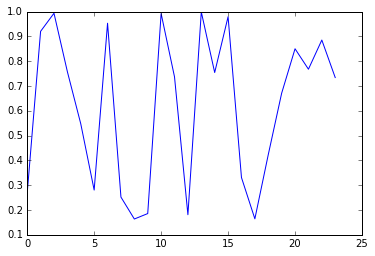

In [19]:
plt.plot(max_bets_over_time.values())

In [22]:
# average betweenness centrality over time
avg_bets_over_time = {} # key: year, value: max betweenness score
for i in range(1989, 2013):
    g = create_graph(i,85)
    bets = nx.betweenness_centrality(g, weight='weight')
    avg_bet = np.sum(bets.values()) / len(bets)
    avg_bets_over_time[i] = avg_bet

print(avg_bets_over_time)

{1989: 0.0042383013811585239, 1990: 0.013249158249158248, 1991: 0.010005000500050005, 1992: 0.01321032103210321, 1993: 0.012159882654932161, 1994: 0.004866694152408437, 1995: 0.01088708870887089, 1996: 0.0064836483648364829, 1997: 0.0049261320689892108, 1998: 0.0053099017384731668, 1999: 0.010145014501450146, 2000: 0.0082226555988932221, 2001: 0.0053713704703803712, 2002: 0.010463046304630463, 2003: 0.014272314986600698, 2004: 0.010257644471930186, 2005: 0.0061282896997182715, 2006: 0.0049974232117089255, 2007: 0.012230956428976234, 2008: 0.013649419363705076, 2009: 0.016373618145855341, 2010: 0.014820771641159997, 2011: 0.011251825182518249, 2012: 0.010397512540369682}


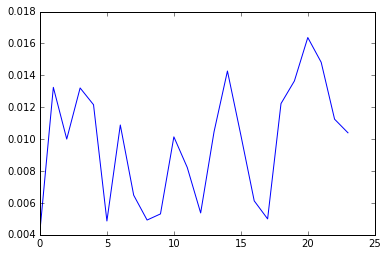

In [24]:
plt.plot(avg_bets_over_time.values())

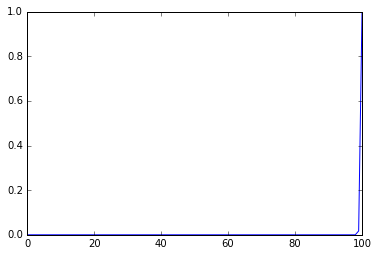

In [42]:
# plot a particular year's betwenness distribution
year = 1991
g = create_graph(year,85)
bets = nx.betweenness_centrality(g, weight='weight')
plt.plot(sorted(bets.values()))


In [1]:
# plot a particular year's eigenvector centrality distribution
year = 2003
g = create_graph(year,85)
eigs = nx.eigenvector_centrality(g, weight='weight')
plt.plot(sorted(eigs.values()))

NameError: name 'create_graph' is not defined

In [13]:
gephi_graph_1990 = nx.write_graphml(g1990, "gephi_1990.graphml")

In [31]:
g1989 = create_graph(1989, 70)
g1989_parties = create_party_dictionary(g1989)
nx.set_node_attributes(g1989, "party", g1989_parties)

In [30]:
# add D/R to each of the nodes
def create_party_dictionary(graph):
    party_dictionary = {}
    for n in nx.nodes(g1989):
        party = n.split("(")[1].split("-")[0]
        party_dictionary[n] = party
    return(party_dictionary)

In [32]:
gephi_graph_1989 = nx.write_graphml(g1989, "gephi_1989.graphml")

In [37]:
g2010 = create_graph(2010, 80)
#g2010_parties = create_party_dictionary(g2010)
#nx.set_node_attributes(g2010, "party", g2010_parties)
gephi_graph_2010 = nx.write_graphml(g2010, "gephi_2013.graphml")

In [5]:
#for each threshold value between 0 and 100, determinds how many senators have that threshold
def avg_degree_by_threshold(year):
    avg_degree = []
    g = create_graph(year, 100)
    nodes = nx.number_of_nodes(g)
    for threshold in range(0, 100):
        g = create_graph(year, threshold)
        degrees = g.degree(weight = None)
        sum_of_edges = sum(degrees.values())
        
        avg_degree.append(sum_of_edges/nodes)
    return avg_degree


/Users/tonyzeng/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1165: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)


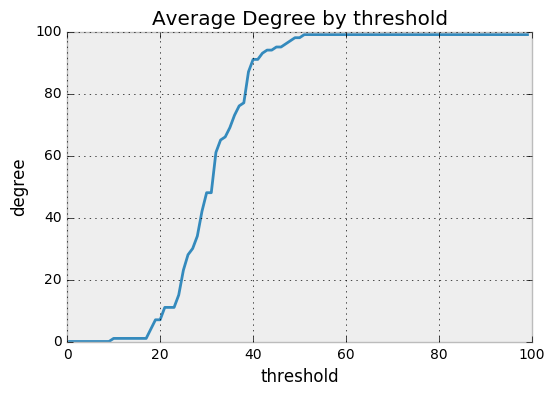

In [6]:
plt.title('Average Degree by threshold')
plt.xlabel('threshold')
plt.ylabel('degree')
plt.plot(avg_degree_by_threshold(1990))

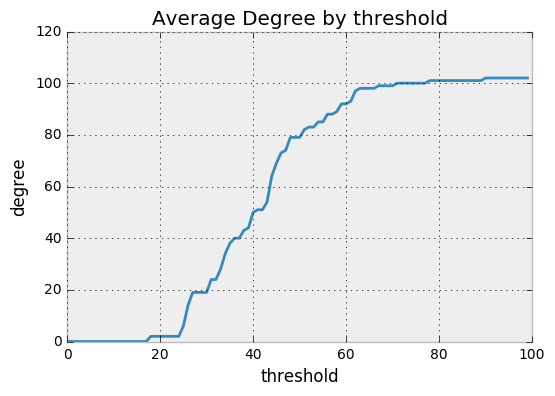

In [7]:
plt.title('Average Degree by threshold')
plt.xlabel('threshold')
plt.ylabel('degree')
plt.plot(avg_degree_by_threshold(2013))

In [10]:
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 100\nNumber of edges: 4950\nAverage degree:  99.0000'

In [42]:
#given a year, threhold, and num_edges to exclude, prunes a graph to exclude 
def prune_weight_scores(year, threshold, num_edges):
    g = create_graph(year,threshold)
    weight = []
    
    #creates edge list
    for edge in g.edges(data = True):
        weight.append(edge[2]['weight'])
    
    #finds cutoff
    vote_threshold = sorted(weight)[4950 - num_edges]
    
    #prunes list 
    out = []
    for edge in g.edges(data = True):
        if edge[2]['weight'] > vote_threshold:
            out.append(edge)
    return nx.from_edgelist(out)

In [43]:
#example of how to use
g = prune_weight_scores(2013, 70, 3000)
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 101\nNumber of edges: 3223\nAverage degree:  63.8218'